<a href="https://colab.research.google.com/github/AnSaradar/Diabetic-Retinopathy-Detection/blob/main/Diabetic_Retinopathy_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset

In [2]:
!git clone https://github.com/kumailht/diabetic-retinopathy

fatal: destination path 'diabetic-retinopathy' already exists and is not an empty directory.


# Importing Libraries

In [3]:
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.applications import VGG16

import cv2

import os
import numpy as np
import itertools
import random

from collections import Counter

from glob import iglob

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input


# Setting The Constant Hyperparameters

In [4]:

BASE_DATASET_FOLDER = "/content/diabetic-retinopathy/data"
TRAIN_FOLDER = "training"
VALIDATION_FOLDER = "validation"
TEST_FOLDER = "test"

IMAGE_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)

TRAIN_BATCH_SIZE = 80
VAL_BATCH_SIZE = 15
batch_size = 32
EPOCHS = 50
LEARNING_RATE = 0.0001




# Setting up the GPU

In [5]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)


# Image Preprocessing

## Edge Detection

In [6]:
def preprocess_image(image):

    image_resized = cv2.resize(image, (224, 224))

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    gray_uint8 = np.uint8(gray)

    blurred = cv2.GaussianBlur(gray_uint8, (3, 3), 0)

    edges = cv2.Canny(blurred, 30, 150)

    processed_image = np.stack((image_resized,)*3, axis=-1)
    processed_image = np.concatenate((processed_image, np.expand_dims(edges, axis=-1)), axis=-1)

    processed_image = preprocess_input(processed_image)

    return processed_image

# Image Handling with Data Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    #preprocessing_function=preprocess_image,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER),
    target_size=IMAGE_SIZE,
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)


val_datagen = ImageDataGenerator(
     #preprocessing_function=preprocess_image,
     rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER),
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    shuffle=False)

test_datagen = ImageDataGenerator(
    #preprocessing_function=preprocess_image,
    rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER),
    target_size=IMAGE_SIZE,
    batch_size=VAL_BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)




Found 1659 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 560 images belonging to 5 classes.


# Model Building & Training VGG16

## Importing VGG Model (Transfer Learning)

In [8]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

## Building The CNN Architicture

In [9]:
model_vgg = Sequential()
model_vgg.add(vgg_model)
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.2))
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.2))
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(64, activation='relu'))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(32, activation='relu'))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(16, activation='relu'))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(5, activation='softmax'))

In [10]:
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

## Model Compiling

In [11]:
model_vgg.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

## Model Fitting

In [12]:
history = model_vgg.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size)

<ipython-input-12-691ec9e2adcb>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_vgg.fit_generator(


Epoch 1/50
20/20 [==============================] - 55s 2s/step - loss: 1.6569 - acc: 0.2356 - val_loss: 1.6031 - val_acc: 0.2555
Epoch 2/50
20/20 [==============================] - 36s 2s/step - loss: 1.6020 - acc: 0.2533 - val_loss: 1.5776 - val_acc: 0.2555
Epoch 3/50
20/20 [==============================] - 29s 1s/step - loss: 1.5867 - acc: 0.2559 - val_loss: 1.5872 - val_acc: 0.2555
Epoch 4/50
20/20 [==============================] - 29s 1s/step - loss: 1.5823 - acc: 0.2565 - val_loss: 1.5728 - val_acc: 0.2555
Epoch 5/50
20/20 [==============================] - 29s 1s/step - loss: 1.5710 - acc: 0.2609 - val_loss: 1.5621 - val_acc: 0.2555
Epoch 6/50
20/20 [==============================] - 30s 1s/step - loss: 1.5676 - acc: 0.2470 - val_loss: 1.5539 - val_acc: 0.2555
Epoch 7/50
20/20 [==============================] - 29s 1s/step - loss: 1.5641 - acc: 0.2457 - val_loss: 1.5523 - val_acc: 0.2555
Epoch 8/50
20/20 [==============================] - 29s 1s/step - loss: 1.5660 - acc: 0.24

## Save The Model & The Weights

In [13]:
MODEL_PATH = os.path.join("Diabetic_Retinopathy_Detector(VGG16).h5")
MODEL_WEIGHTS_PATH = os.path.join("Diabetic_Retinopathy_Model_Weights(VGG16).h5")
model_vgg.save(MODEL_PATH)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Testing The Model

In [16]:
test_loss, test_accuracy = model_vgg.evaluate(test_generator, steps=test_generator.n // batch_size)
print("Test Accuracy:", test_accuracy)

17/17 [==============================] - 5s 71ms/step - loss: 1.3980 - acc: 0.0000e+00
Test Accuracy: 0.0


## Training & Validation Curve

In [17]:
def plot_training_history(history):
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

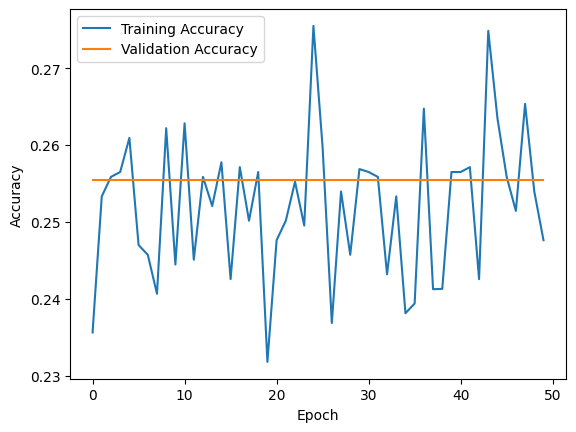

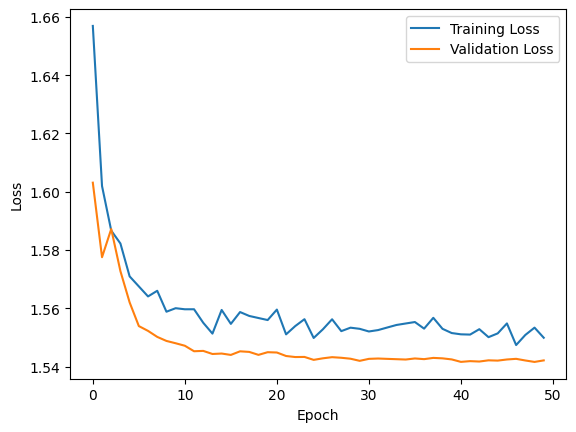

In [18]:
plot_training_history(history)

# Model Building & Training RESNET50

## Import The RESNET 50 Model

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [20]:
base_model = ResNet50(weights='imagenet', include_top=False)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


## Building the Model Architcture

In [21]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=predictions)

In [22]:
model_resnet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Model Training

In [24]:
history = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size)

Epoch 1/50
20/20 [==============================] - 33s 2s/step - loss: 1.5988 - accuracy: 0.2457 - val_loss: 1.5549 - val_accuracy: 0.2555
Epoch 2/50
20/20 [==============================] - 28s 1s/step - loss: 1.5868 - accuracy: 0.2481 - val_loss: 1.5773 - val_accuracy: 0.2555
Epoch 3/50
20/20 [==============================] - 29s 1s/step - loss: 1.5808 - accuracy: 0.2717 - val_loss: 1.5782 - val_accuracy: 0.2555
Epoch 4/50
20/20 [==============================] - 31s 2s/step - loss: 1.6223 - accuracy: 0.2445 - val_loss: 1.6282 - val_accuracy: 0.2555
Epoch 5/50
20/20 [==============================] - 28s 1s/step - loss: 1.5874 - accuracy: 0.2679 - val_loss: 1.5537 - val_accuracy: 0.2463
Epoch 6/50
20/20 [==============================] - 28s 1s/step - loss: 1.5712 - accuracy: 0.2525 - val_loss: 1.5654 - val_accuracy: 0.2482
Epoch 7/50
20/20 [==============================] - 29s 1s/step - loss: 1.5651 - accuracy: 0.2590 - val_loss: 1.5619 - val_accuracy: 0.2537
Epoch 8/50
20/20 [==

## Model Evaluation

In [25]:
test_loss, test_acc = model_resnet.evaluate(test_generator, steps=test_generator.samples//batch_size)
print('Test accuracy:', test_acc)

17/17 [==============================] - 3s 91ms/step - loss: 1.3000 - accuracy: 0.5490
Test accuracy: 0.5490196347236633


## Training & Validation Curve

In [27]:
def plot_training_history_RESNET50(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

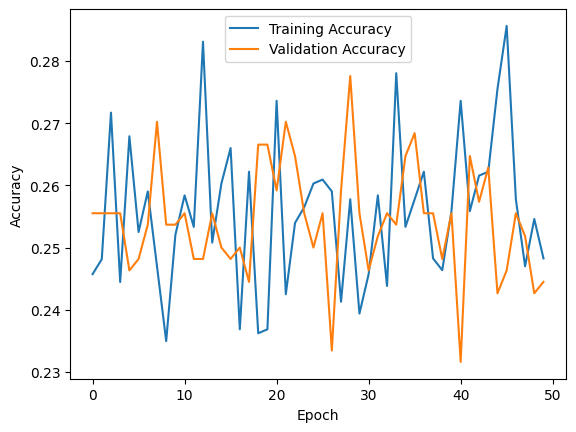

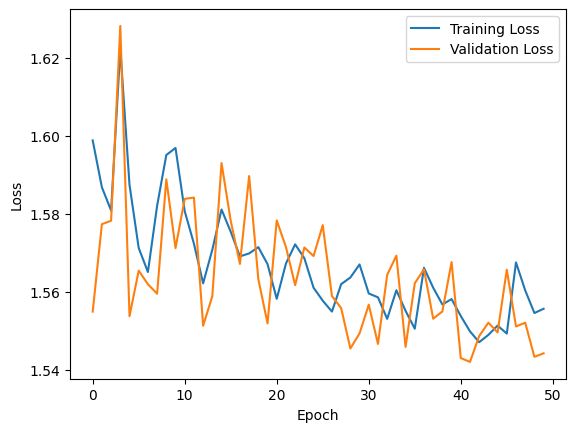

In [28]:
plot_training_history_RESNET50(history)

Mode

In [29]:
MODEL_PATH = os.path.join("Diabetic_Retinopathy_Detector(RESNET50).h5")
MODEL_WEIGHTS_PATH = os.path.join("Diabetic_Retinopathy_Model_Weights(RESNET50).h5")
model_resnet.save(MODEL_PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Try your own image

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def classify_image(image_url, model):

    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    img = img.resize((150, 150))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    class_probabilities = model.predict(img_array)
    predicted_class = np.argmax(class_probabilities)

    return predicted_class

In [ ]:
image_url = "URL_OF_YOUR_IMAGE"
predicted_class = classify_image(image_url, model_vgg)
print("Predicted Class:", predicted_class)